In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import glob
import pickle
import pandas as pd
import pyccl as ccl
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import pyccl as ccl
import clmm
from scipy import stats
from clmm import Cosmology

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/')
import model_completeness as comp
import model_purity as pur
import model_halo_mass_function as hmf
import model_richness_mass_relation as rm_relation
import model_cluster_abundance as cl_count

def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

In [2]:
where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'

In [3]:
logm_edges = np.linspace(14.3, 15.5, 5)
redshift_edges = np.linspace(0.2, 1, 6)
richness_edges = np.exp(np.linspace(np.log(20), np.log(200), 7))
log10m0, z0 = np.log10(10**14.3), .5
proxy_mu0, proxy_muz, proxy_mulog10m =  3.2,0.078,2.22
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  0.56,0,0.1
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]

In [4]:
Z_bin = binning(redshift_edges)
LogMass_bin = binning(logm_edges)
Richness_bin = binning(richness_edges)

In [5]:
def pinocchio_datavector(index_simu=1, plot=True):
    file=glob.glob(where_cat)[index_simu]
    dat = pd.read_csv(file ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
    ra, dec, redshift, Mvir = dat['ra'], dat['dec'], dat['z'], dat['M']/0.6777
    mask = np.log10(Mvir) > 14.2
    ra, dec, redshift, Mvir = ra[mask], dec[mask], redshift[mask], Mvir[mask]
    richness = np.exp(rm_relation.lnLambda_random(np.log10(Mvir), redshift, theta_rm))
    N_mass_redshift, a, b = np.histogram2d(np.log10(Mvir),redshift,  bins = [logm_edges, redshift_edges, ])
    N_richness_redshift, a, b = np.histogram2d(richness, redshift, bins = [richness_edges, redshift_edges, ])
    Mean_mass_mass_redshift = stats.binned_statistic_2d(np.log10(Mvir),redshift, Mvir, 'mean', bins=[logm_edges, redshift_edges]).statistic
    Mean_mass_richness_redshift = stats.binned_statistic_2d(richness, redshift, Mvir, 'mean', bins=[richness_edges, redshift_edges]).statistic
    if plot==True:
        plt.figure(figsize=(5,4))
        plt.scatter(Mvir, richness, alpha=0.2)
        plt.loglog()
        plt.ylabel('richness', fontsize=12)
        plt.xlabel(r'M $[M_\odot]$', fontsize=12)
        plt.grid(which='both')
        plt.tick_params(axis='both', which = 'major', labelsize= 13)

    data = {'count_richness_redshift': N_richness_redshift,
         'richness_bins': Richness_bin,
         'redshift_bins': Z_bin,
         'log10Mass_bin':LogMass_bin,
         'count_mass_redshift': N_mass_redshift,
         'mean_mass_richness_redshift': Mean_mass_richness_redshift,
         'mean_mass_mass_redshift': Mean_mass_mass_redshift,
        }
    save_pickle(data, f'/pbs/throng/lsst/users/cpayerne/capish/pinocchio_data_vector/data_vector_pinocchio_mock_{index_simu}.pkl', )
    return N_mass_redshift, N_richness_redshift

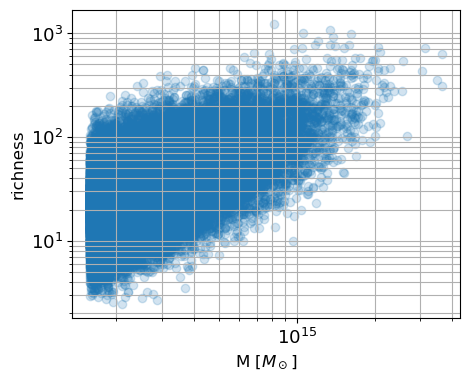

In [6]:
N_mass_redshift_0, N_richness_redshift_0 = pinocchio_datavector(index_simu=0)
N_mass_redshift_1, N_richness_redshift_1 = pinocchio_datavector(index_simu=1, plot=False)
N_mass_redshift_2, N_richness_redshift_2 = pinocchio_datavector(index_simu=2, plot=False)
N_mass_redshift_3, N_richness_redshift_3 = pinocchio_datavector(index_simu=3, plot=False)

# Comparison to prediction

In [7]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
#halo model
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)

In [8]:
richness_grid = np.logspace(np.log10(20), np.log10(200), 310)
logm_grid = np.linspace(14.2, 16, 200)
z_grid = np.linspace(.2, 1, 301)

In [9]:
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
params = {'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmo, 'halo_mass_distribution': hmd, 'params_concentration_mass_relation':None}
adds = {'add_purity' : False, 'add_completeness':False}
compute = {'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 
           'compute_completeness':False, 'compute_purity':False ,'compute_halo_bias':False,
          'compute_dNdzdlogMdOmega_log_slope': False}

In [10]:
count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)

In [11]:
integrand_count = cl_count.define_count_integrand(count_modelling_new, adds)

In [12]:
Omega = 0.25*(4*np.pi)
Nth = Omega * cl_count.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = integrand_count, grids = grids)

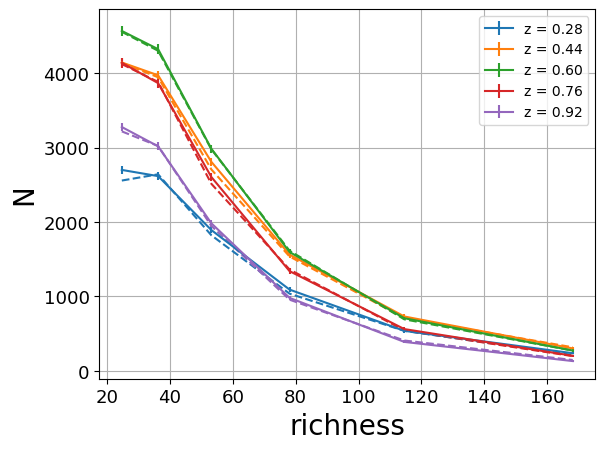

In [13]:
for i in range(5):
    plt.errorbar(np.mean(Richness_bin, axis=1), Nth[:,i], np.sqrt(Nth[:,i]), label = 'z = '+f'{np.mean(Z_bin[i]):.2f}', color = f'C{i}')
    plt.plot(np.mean(Richness_bin, axis=1),  N_richness_redshift_0[:,i], '--', color = f'C{i}')
plt.grid(which='both')
plt.legend()
plt.xlabel('richness', fontsize=20,)
plt.ylabel('N', fontsize=20,)
plt.tick_params(axis='both', which = 'major', labelsize= 13)